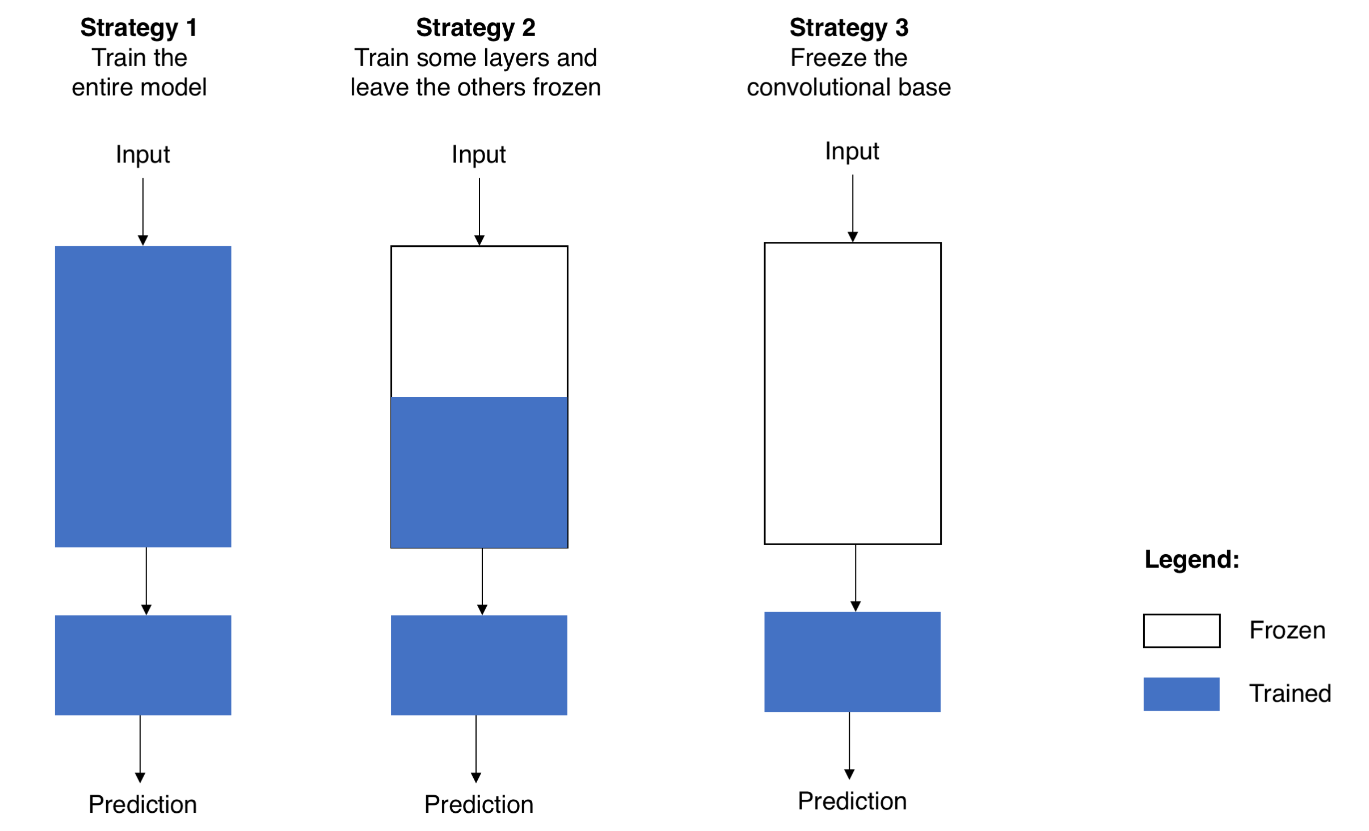

In [1]:
from IPython.display import Image
Image("strategies.png")

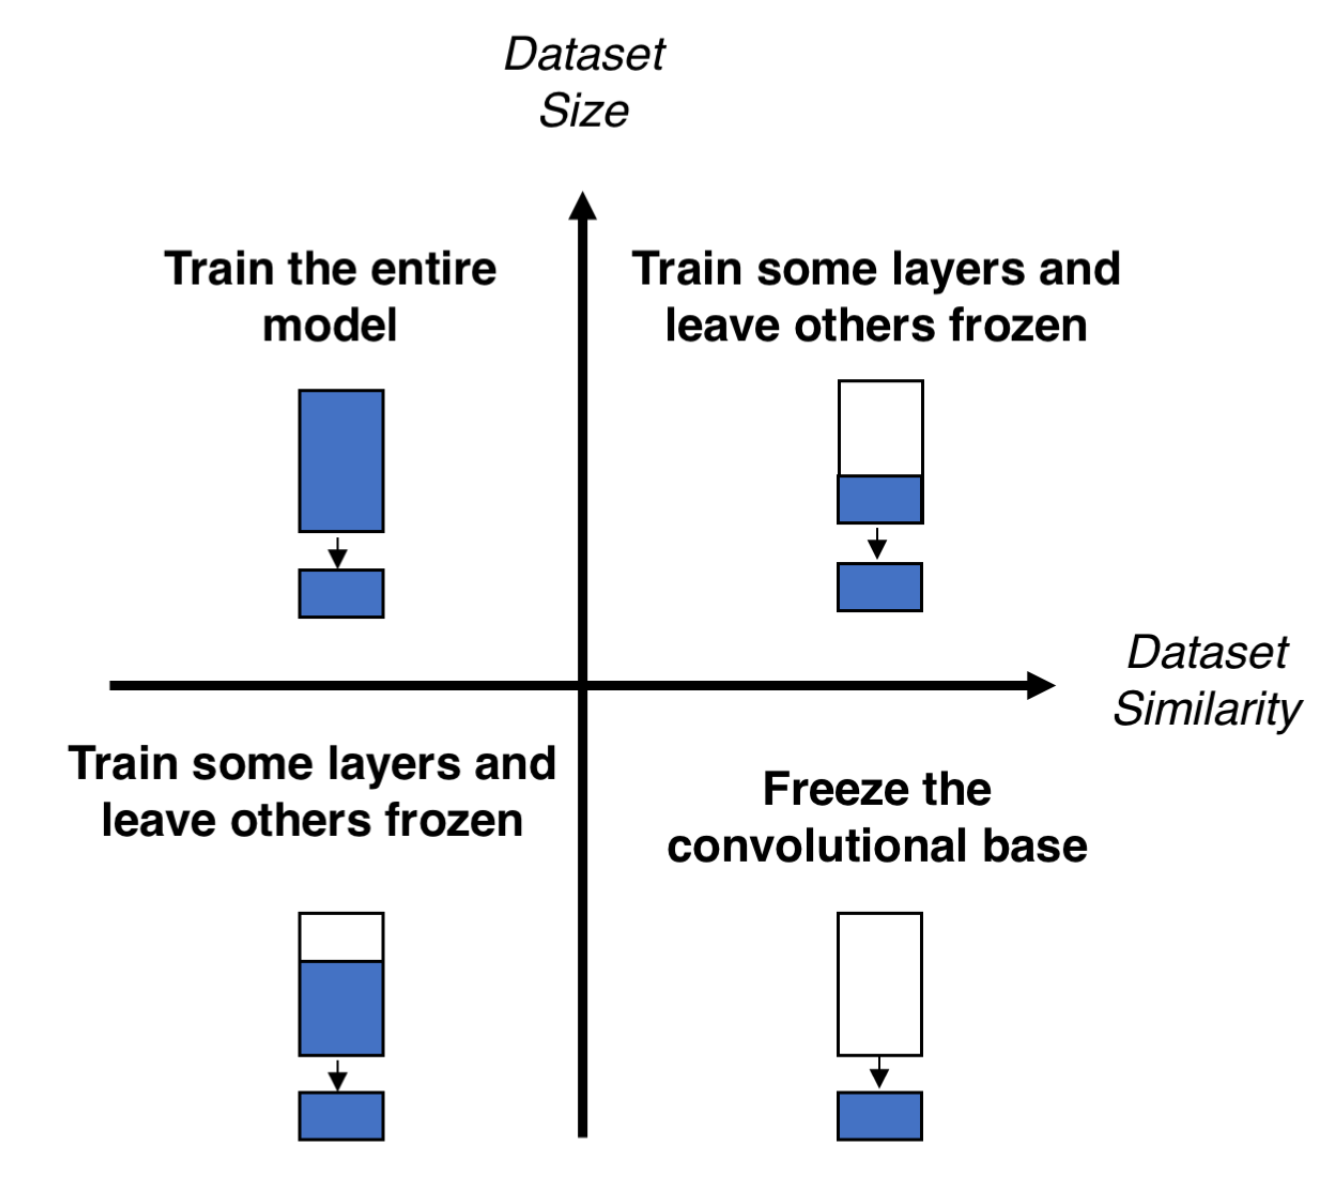

In [2]:
from IPython.display import Image
Image("approaches.png")

Here we will use feature extraction by extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer. 
So you can do the following:

# The Convolutional Base (conv_base)

In [3]:
img_width, img_height, img_channels = 128, 128, 3  # Default input size for MobileNetV2 is 224, 224

In [4]:
# Instantiate convolutional base

from keras.applications.mobilenet_v2 import MobileNetV2

conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, img_channels))

conv_base.summary()

Using TensorFlow backend.


Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [5]:
conv_base.output_shape

(None, 4, 4, 1280)

In [6]:
input_dim = conv_base.output_shape[1]*conv_base.output_shape[2]*conv_base.output_shape[3]

# Data preparation - Data augmentation

In [7]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = "../data/TTG_TUR/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_SIM_dir = os.path.join(train_dir, 'SIM')
train_NAO_dir = os.path.join(train_dir, 'NAO')
validation_SIM_dir = os.path.join(validation_dir, 'SIM')
validation_NAO_dir = os.path.join(validation_dir, 'NAO')
test_SIM_dir = os.path.join(test_dir, 'SIM')
test_NAO_dir = os.path.join(test_dir, 'NAO')


train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All imgs will be resized to img_height x img_width
        target_size=(img_height, img_width),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


# Fully Connected Layers (FCL) classifier

## Modeling

This classifier adds a stack of fully-connected layers that is fed by the features extracted from the convolutional base.

In [8]:
# Define model

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) #help fighting overfitting
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               5243136   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 7,501,377
Trainable params: 7,467,265
Non-trainable params: 34,112
_________________________________________________________________


In [9]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 160


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 mobilenetv2_1.00_128
1 flatten_1
2 dense_1
3 dropout_1
4 dense_2


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 

If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with data augmentation.

## Compile model

In [13]:
import pandas as pd

def info_layers(conv_base,model):
    
    list_layer_name = []
    list_trainable = []

    for layer in conv_base.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    

    df1 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    list_layer_name = []
    list_trainable = []

    for layer in model.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    
    df2 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    df2 = df2[1:]

    df= pd.concat([df1,df2])
    df.reset_index(drop=True,inplace=True)
    
    pd.options.display.max_rows = len(df)
    
    return df

In [14]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,Conv1_pad,True
2,Conv1,True
3,bn_Conv1,True
4,Conv1_relu,True
5,expanded_conv_depthwise,True
6,expanded_conv_depthwise_BN,True
7,expanded_conv_depthwise_relu,True
8,expanded_conv_project,True
9,expanded_conv_project_BN,True


In [15]:
# i = 0

# for layer in conv_base.layers:
#     sp = '      '[len(layer.name)-4:]
#     print(i,layer.name, sp, layer.trainable)
#     i+=1
    
# for layer in model.layers:
#     sp = '      '[len(layer.name)-4:]
#     print(i,layer.name, sp, layer.trainable)
#     i+=1

In [16]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [17]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-11-27 06:30:54.389096


In [18]:
# Train model
# Using EarlyStopping

# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 198s 2s/step - loss: 0.8242 - acc: 0.6630 - val_loss: 0.6464 - val_acc: 0.7319
Epoch 2/30
100/100 [==============================] - 203s 2s/step - loss: 0.7030 - acc: 0.6956 - val_loss: 0.3049 - val_acc: 0.7551
Epoch 3/30
100/100 [==============================] - 141s 1s/step - loss: 0.6277 - acc: 0.7280 - val_loss: 0.5804 - val_acc: 0.7389
Epoch 4/30
100/100 [==============================] - 139s 1s/step - loss: 0.6474 - acc: 0.7085 - val_loss: 0.6109 - val_acc: 0.7398
Epoch 5/30
100/100 [==============================] - 135s 1s/step - loss: 0.5831 - acc: 0.7415 - val_loss: 0.6675 - val_acc: 0.7520


## Save model

In [19]:
model.save("../models/MobileNetV2_firebreak_detection_feature_extraction_data_augmentation_FC_model.h5")

## Model evaluation

### Learning curves

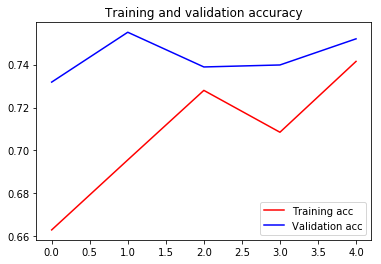

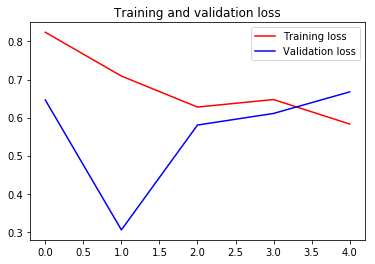

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/MobileNetV2_firebreak_detection_feature_extraction_data_augmentation_FC_history.csv", index = False)

In [22]:
t2 = datetime.datetime.now()
(print(t2))
print(t2-t1)

2019-11-27 06:44:34.734363
0:13:40.345267


### Model in action

In [23]:
def prediction_dataframe(generator):
    """ Generate dataframe with filename, probability, and class of the image
    """
    

    # Predict from generator (returns probabilities)
    pred=model.predict_generator(generator, steps=len(generator), verbose=1)

    # Get classes by np.round
    cl = np.round(pred)
    # Get filenames (set shuffle=false in generator is important)
    filenames=generator.filenames

    # Data frame
    results=pd.DataFrame({"file_name":filenames,"prob":pred[:,0], "class":cl[:,0]})
    results['file_name'] = results['file_name'].apply(lambda x: x.split('\\')[-1])
    
    return results

In [24]:
# obtaining predictions for test images

results = prediction_dataframe(test_generator)

32/32 [==============================] - 30s 926ms/step


In [25]:
results.head()

,file_name,prob,class
0,2017-12-12 11-56-38_NAO.jpeg,0.032426,0.0
1,2018-01-09 16-17-15_NAO.jpeg,0.127641,0.0
2,2018-01-09 17-10-54_NAO.jpeg,0.050930,0.0
3,2018-01-30 08-53-00_NAO.jpeg,0.247355,0.0
4,2018-01-30 09-07-13_NAO.jpeg,0.169942,0.0


In [26]:
# Define function to visualize predictions
import random
from keras.preprocessing import image

def visualize_predictions(classifier, n_cases, results):
    """ shows images and prediction considering threshold of 0.5 and test images"""
    
    for i in range(0,n_cases):
        path = random.choice([test_NAO_dir, test_SIM_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Make prediction
        
        idx = results.index[results['file_name'] == random_img].tolist()
        prediction = results['prob'].loc[idx[0]]

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print(random_img)
            print('Not firebreack')
        else:
            print(random_img)
            print('Firebreak')

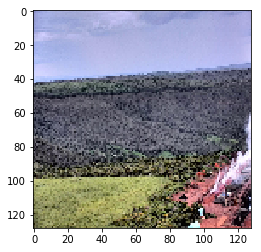

2018-03-18 18-05-08_NAO.jpeg
Not firebreack


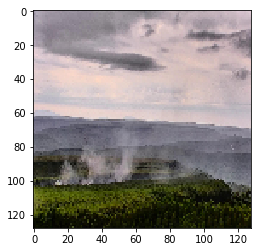

2018-11-04 07-39-09_NAO.jpeg
Not firebreack


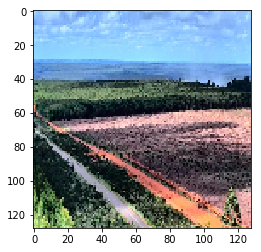

2019-01-30 10-10-36_NAO.jpeg
Not firebreack


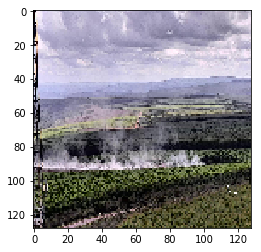

2018-03-17 10-57-00_SIM.jpeg
Not firebreack


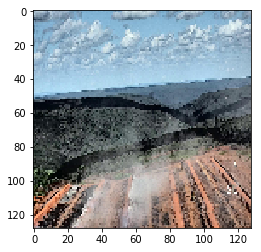

2018-03-14 14-29-26_NAO.jpeg
Not firebreack


In [27]:
# Visualize predictions
visualize_predictions(model, 5, results)

# Global average pooling

## Modeling

Instead of adding a stack of fully-connected layers, as before, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

Note that we are talking about a sigmoid activated layers instead of a softmax one, which is what is recommended by [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf). We are changing to the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss (see Chollet's book). Accordingly, it was necessary to do this small modification to the original proposal of Lin et al. (2013).

In [29]:
# Instantiate convolutional base

from keras.applications.mobilenet_v2 import MobileNetV2

conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, img_channels))

conv_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [30]:
#Define model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [31]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158


In [32]:
conv_base.trainable = False

In [33]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 2


In [34]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 mobilenetv2_1.00_128
1 global_average_pooling2d_1
2 dense_3


## Compile model

In [35]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,Conv1_pad,True
2,Conv1,True
3,bn_Conv1,True
4,Conv1_relu,True
5,expanded_conv_depthwise,True
6,expanded_conv_depthwise_BN,True
7,expanded_conv_depthwise_relu,True
8,expanded_conv_project,True
9,expanded_conv_project_BN,True


In [36]:
# i = 0

# for layer in conv_base.layers:
#     sp = '      '[len(layer.name)-4:]
#     print(i,layer.name, sp, layer.trainable)
#     i+=1
    
# for layer in model.layers:
#     sp = '      '[len(layer.name)-4:]
#     print(i,layer.name, sp, layer.trainable)
#     i+=1

In [37]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [38]:
# Train model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/100
100/100 [==============================] - 132s 1s/step - loss: 0.7997 - acc: 0.4700 - val_loss: 0.8151 - val_acc: 0.3679
Epoch 2/100
100/100 [==============================] - 146s 1s/step - loss: 0.7137 - acc: 0.5670 - val_loss: 0.8784 - val_acc: 0.4126
Epoch 3/100
100/100 [==============================] - 163s 2s/step - loss: 0.6408 - acc: 0.6380 - val_loss: 0.8317 - val_acc: 0.5131
Epoch 4/100
100/100 [==============================] - 171s 2s/step - loss: 0.6288 - acc: 0.6720 - val_loss: 0.7879 - val_acc: 0.5701
Epoch 5/100
100/100 [==============================] - 152s 2s/step - loss: 0.6186 - acc: 0.6991 - val_loss: 0.6689 - val_acc: 0.6159
Epoch 6/100
100/100 [==============================] - 141s 1s/step - loss: 0.6081 - acc: 0.7145 - val_loss: 0.7578 - val_acc: 0.6321
Epoch 7/100
100/100 [==============================] - 137s 1s/step - loss: 0.5954 - acc: 0.7290 - val_loss: 0.7987 - val_acc: 0.6744
Epoch 8/100
100/100 [==============================] - 143s 1s

## Save model

In [39]:
model.save("../models/MobileNetV2_firebreak_detection_feature_extraction_data_augmentation_GAP_model.h5")

# Model evaluation

## Learning curves

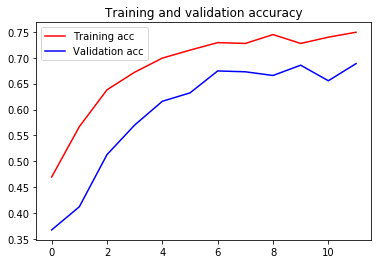

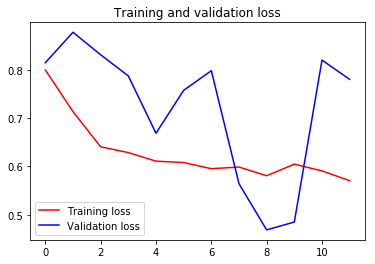

In [40]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/MobileNetV2_firebreak_detection_feature_extraction_data_augmentation_GAP_history.csv", index = False)

In [42]:
t3 = datetime.datetime.now()
(print(t3))
print(t3-t2)

2019-11-27 07:33:00.352561
0:48:25.618198


## Model in action

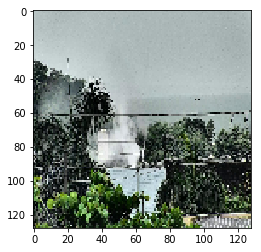

2018-01-30 08-59-45_SIM.jpeg
Not firebreack


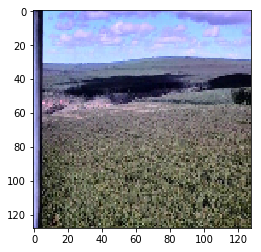

2019-07-28 10-03-55_SIM.jpeg
Not firebreack


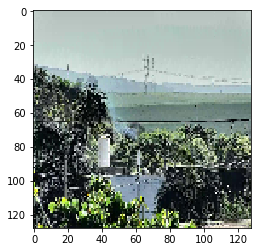

2018-01-31 09-42-06_SIM.jpeg
Not firebreack


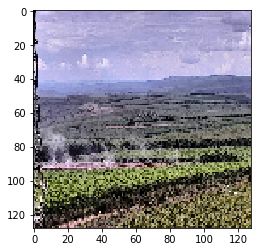

2018-03-13 15-35-28_SIM.jpeg
Not firebreack


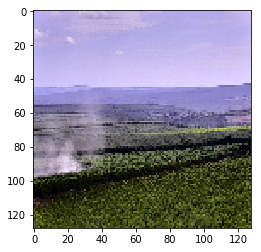

2018-11-02 08-16-28_SIM.jpeg
Not firebreack


In [44]:
# Visualize predictions
visualize_predictions(model, 5, results)

**REFERENCES:**

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

https://github.com/fchollet/deep-learning-with-python-notebooks